In [50]:
from core.main_classes.functions import *
from core.main_classes.domains import HyperParalelipiped
from core.main_classes.spaces import *
from core.main_classes.mappings import *
from core.aux.other import simple_property

import seaborn as sns

Create the domain for the functions

In [51]:
####################
# Create model space
####################
# Edit region -------------
physical_parameters = ['param_1', 'param_2', 'param_3']

# Edit region -------------

physical_parameters_symbols = {'param_1': '$param_1$', 'param_2': '$param_2$', 'param_3': '$param_3$'}
no_of_params = len(physical_parameters)
domain = HyperParalelipiped(bounds=[[0, 1]], fineness=1000)
constituent_models_spaces = [PCb(domain=domain) for _ in physical_parameters]
# Create a dictionary with physical_parameters as keys
models_dict = {param: model_space for param, model_space in zip(physical_parameters, constituent_models_spaces)}
M = DirectSumSpace(tuple(constituent_models_spaces))

In [52]:
###################################
# Create property mappings and space
###################################
# Edit region -------------
how_many_targets = 1000
enquiry_points = np.linspace(domain.bounds[0][0], 
                             domain.bounds[0][1], 
                             how_many_targets)
widths = 0.2 * np.ones_like(enquiry_points) # same units as domain (km here)
# Edit region -------------

P = RN(dimension=how_many_targets)
# Averages
target_types = {'param_1': Gaussian_1D,
                'param_2': Null_1D,
                'param_3': Null_1D}
T_1 = simple_property(M=M, P=P, target_types=target_types, domain=domain, 
                      enquiry_points=enquiry_points, widths=widths, models_dict=models_dict)
# Boxcar
target_types = {'param_1': Bump_1D,
                'param_2': Null_1D,
                'param_3': Null_1D}
T_2 = simple_property(M=M, P=P, target_types=target_types, domain=domain, 
                      enquiry_points=enquiry_points, widths=widths, models_dict=models_dict)
# Bump
target_types = {'param_1': Boxcar_1D,
                'param_2': Null_1D,
                'param_3': Null_1D}
T_3 = simple_property(M=M, P=P, target_types=target_types, domain=domain, 
                      enquiry_points=enquiry_points, widths=widths, models_dict=models_dict)

# Derivatives
target_types = {'param_1': Dgaussian_1D,
                'param_2': Null_1D,
                'param_3': Null_1D}
DT_1 = simple_property(M=M, P=P, target_types=target_types, domain=domain, 
                      enquiry_points=enquiry_points, widths=widths, models_dict=models_dict)
# Boxcar
target_types = {'param_1': Dbump_1D,
                'param_2': Null_1D,
                'param_3': Null_1D}
DT_2 = simple_property(M=M, P=P, target_types=target_types, domain=domain, 
                      enquiry_points=enquiry_points, widths=widths, models_dict=models_dict)
# Bump
target_types = {'param_1': Haar_1D,
                'param_2': Null_1D,
                'param_3': Null_1D}
DT_3 = simple_property(M=M, P=P, target_types=target_types, domain=domain, 
                      enquiry_points=enquiry_points, widths=widths, models_dict=models_dict)

# Local Averages

In [53]:
gaussian = Gaussian_1D(domain=domain, center=0.5, width=0.6)
bump = Bump_1D(domain=domain, center=0.5, width=0.6)
boxcar = Boxcar_1D(domain=domain, center=0.5, width=0.6)

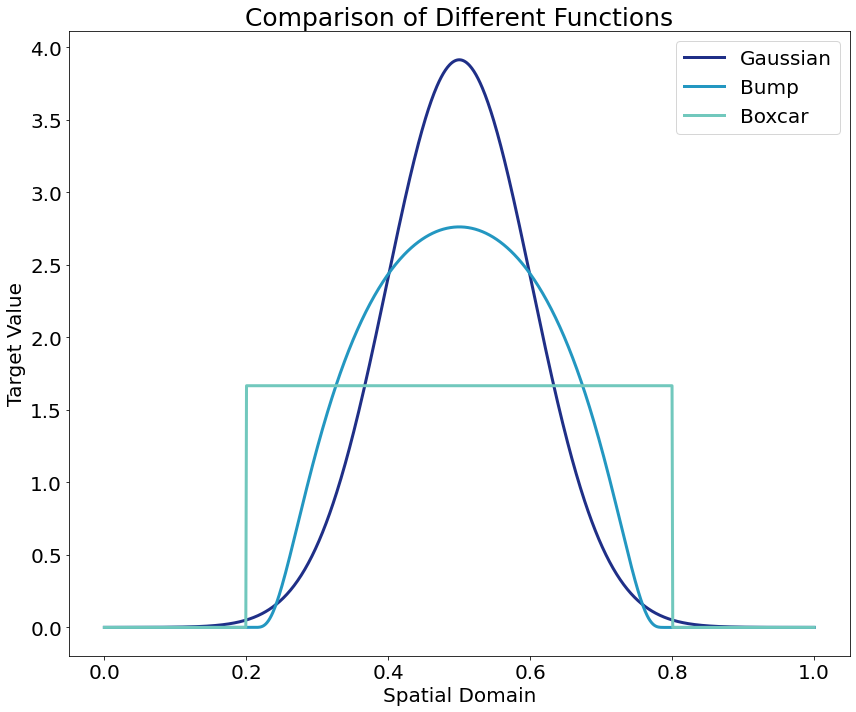

In [54]:
%matplotlib inline
palette = sns.color_palette('YlGnBu', n_colors=100)
plt.figure('local averages', figsize=(12,10))
plt.plot(domain.mesh, gaussian.evaluate(domain.mesh)[1], color=palette[90], linewidth=3, label='Gaussian')
plt.plot(domain.mesh, bump.evaluate(domain.mesh)[1], color=palette[60], linewidth=3, label='Bump')
plt.plot(domain.mesh, boxcar.evaluate(domain.mesh)[1], color=palette[40], linewidth=3, label='Boxcar')

# Add labels and title
plt.xlabel('Spatial Domain', fontsize=20)
plt.ylabel('Target Value', fontsize=20)
plt.title('Comparison of Different Functions', fontsize=25)

# Customize tick marks and labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add legend
plt.legend(fontsize=20)

# Fine-tune aesthetics
plt.tight_layout()

# Save the plot as an image for inclusion in the research paper
plt.savefig('plot.png', dpi=300)  # Save the plot as a high-resolution image
plt.show()

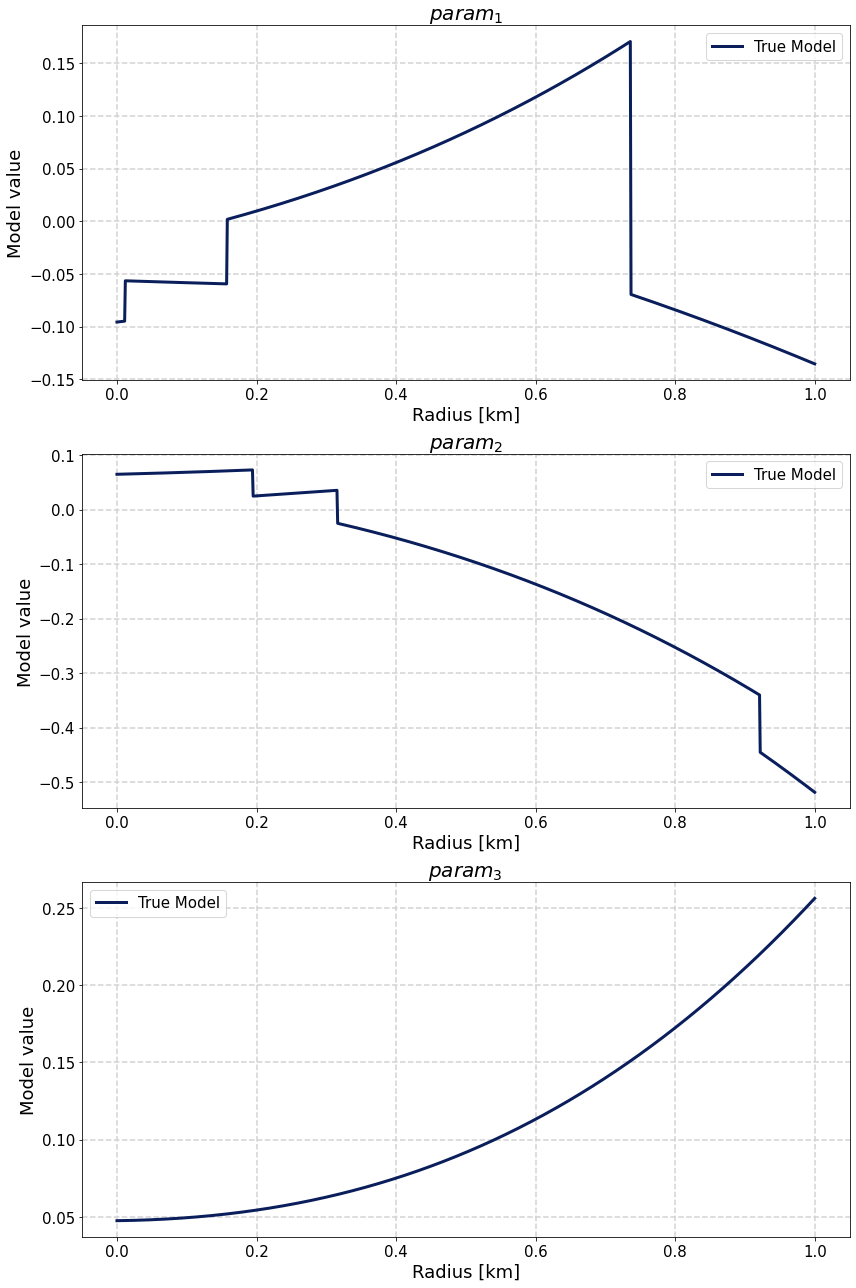

In [55]:
#################################
# Create fake true model and data
#################################
true_model = M.random_member(args_list=[(15,), (111,), (123,)])

fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12,6*len(physical_parameters)))
for i, (submodel, physical_parameter) in enumerate(zip(true_model, physical_parameters)):
    axes[i].plot(domain.mesh, submodel.evaluate(domain.mesh)[1], 
            label='True Model', color=palette[99], linewidth=3)
    axes[i].set_title(physical_parameters_symbols[physical_parameter], fontsize=20)
    axes[i].set_xlabel('Radius [km]', fontsize=18)
    axes[i].set_ylabel('Model value', fontsize=18)
    axes[i].tick_params(axis='both', which='major', labelsize=15)
    axes[i].legend(fontsize=15)
    axes[i].grid(True, linestyle='--', linewidth=1.5, color='lightgray')  # Add gridlines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('truth.png', dpi=300, bbox_inches='tight')  # Save figure
plt.show()

# Effect of these targets on a model

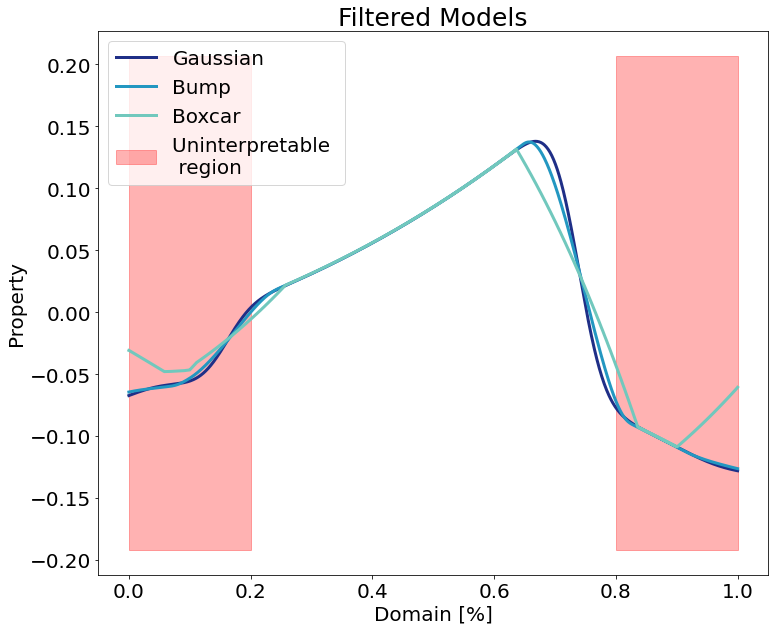

In [56]:
y_min = np.min(T_1.map(true_model))*1.5
y_max = np.max(T_1.map(true_model))*1.5
plt.figure('properties', figsize=(12,10))
plt.plot(enquiry_points, T_1.map(true_model), color=palette[90], linewidth=3, label='Gaussian')
plt.plot(enquiry_points, T_2.map(true_model), color=palette[60], linewidth=3, label='Bump')
plt.plot(enquiry_points, T_3.map(true_model), color=palette[40], linewidth=3, label='Boxcar')
plt.fill_betweenx([y_min, y_max], 0, widths[0], color='red', alpha=0.3, label='Uninterpretable \n region')
plt.fill_betweenx([y_min, y_max], domain.bounds[0][1] - widths[0], domain.bounds[0][1], color='red', alpha=0.3)
plt.legend(fontsize=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title('Filtered Models', fontsize=25)
plt.xlabel('Domain [%]', fontsize=20)
plt.ylabel('Property', fontsize=20)
plt.savefig('Local_Avg_Properties.pdf', dpi=300, bbox_inches='tight')
plt.show()


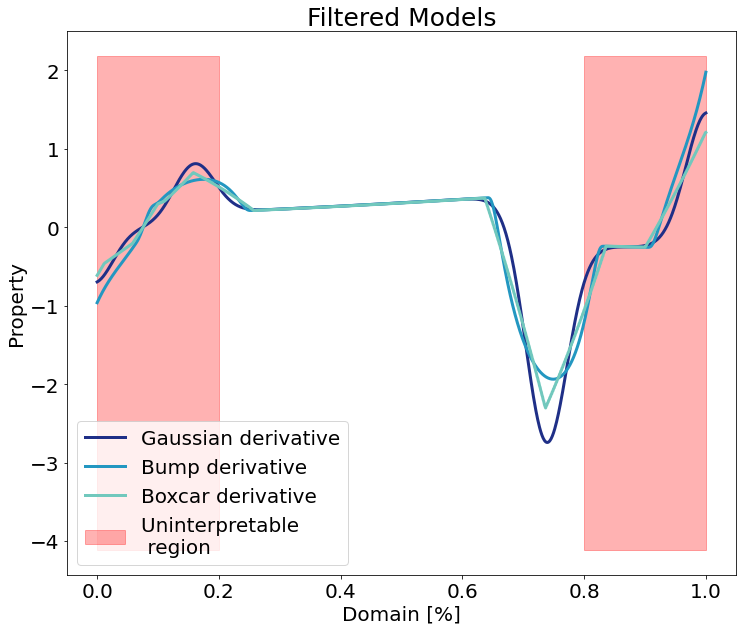

In [59]:
y_min = np.min(DT_1.map(true_model))*1.5
y_max = np.max(DT_1.map(true_model))*1.5
plt.figure('properties', figsize=(12,10))
plt.plot(enquiry_points, DT_1.map(true_model), color=palette[90], linewidth=3, label='Gaussian derivative')
plt.plot(enquiry_points, DT_2.map(true_model), color=palette[60], linewidth=3, label='Bump derivative')
plt.plot(enquiry_points, DT_3.map(true_model), color=palette[40], linewidth=3, label='Boxcar derivative')
plt.fill_betweenx([y_min, y_max], 0, widths[0], color='red', alpha=0.3, label='Uninterpretable \n region')
plt.fill_betweenx([y_min, y_max], domain.bounds[0][1] - widths[0], domain.bounds[0][1], color='red', alpha=0.3)
plt.legend(fontsize=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title('Filtered Models', fontsize=25)
plt.xlabel('Domain [%]', fontsize=20)
plt.ylabel('Property', fontsize=20)
plt.savefig('Local_Deriv_Properties.pdf', dpi=300, bbox_inches='tight')
plt.show()